# `CIFAR10` Image Classification Challenge (Version-0.4.3)
## Convolutional Networks and Image Augmentation

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tf_hub

TensorFlow 2.x selected.


In [0]:
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from matplotlib import style
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import logging
import math
import numpy as np
import os
import pandas as pd
import urllib3

In [0]:
logger = tf.get_logger()

In [0]:
logger.setLevel(level=logging.ERROR)
style.use(style='ggplot')
tfds.disable_progress_bar()
urllib3.disable_warnings(category=urllib3.exceptions.InsecureRequestWarning)

In [0]:
splitting = tfds.Split.ALL.subsplit(weighted=(70, 20, 10))
splitting

(NamedSplitAll()(tfds.percent[0:70]),
 NamedSplitAll()(tfds.percent[70:90]),
 NamedSplitAll()(tfds.percent[90:100]))

In [0]:
dataset_cifar10, dataset_info = tfds.load(name='cifar10', split=splitting, as_supervised=True, with_info=True)

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.


In [0]:
dataset_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=1.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [0]:
splitting = 10000

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

(x_train, y_train), (x_valid, y_valid) = (x_train[:-splitting], y_train[:-splitting]), (x_train[-splitting:], y_train[-splitting:])

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)
(10000, 32, 32, 3) (10000, 1)


In [0]:
class_labels = np.array(dataset_info.features['label'].names)

In [0]:
def plot_augmented_images(images_arr):
  fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
  axes = axes.flatten()

  for image, ax in zip(images_arr, axes):
    ax.imshow(image)
    ax.grid(False)
  
  plt.tight_layout()
  plt.show()

In [0]:
image_data_gen_train = ImageDataGenerator(rotation_range=45, 
                                          width_shift_range=0.15, 
                                          height_shift_range=0.15, 
                                          brightness_range=[0.2, 1], 
                                          shear_range=0.3, 
                                          zoom_range=0.5, 
                                          horizontal_flip=True, 
                                          vertical_flip=True, 
                                          rescale=1./255)

In [0]:
train_data_generator = image_data_gen_train.flow(x=x_train, y=y_train)

In [0]:
print(len(train_data_generator))
print(train_data_generator[0][0].shape)
print(train_data_generator[0][1].shape)

1250
(32, 32, 32, 3)
(32, 1)


In [0]:
image_data_gen_valid = ImageDataGenerator(rescale=1./255)

In [0]:
valid_data_generator = image_data_gen_valid.flow(x=x_valid, y=y_valid)

In [0]:
print(len(valid_data_generator))
print(valid_data_generator[0][0].shape)
print(valid_data_generator[0][1].shape)

313
(32, 32, 32, 3)
(32, 1)


In [0]:
augmented_tr_images = [train_data_generator[0][0][j] for j in range(5) for i in range(5)]
print(len(augmented_tr_images))
labs = [train_data_generator[0][1][j][0] for j in range(5)]
print(labs)

25
[2, 8, 3, 4, 4]


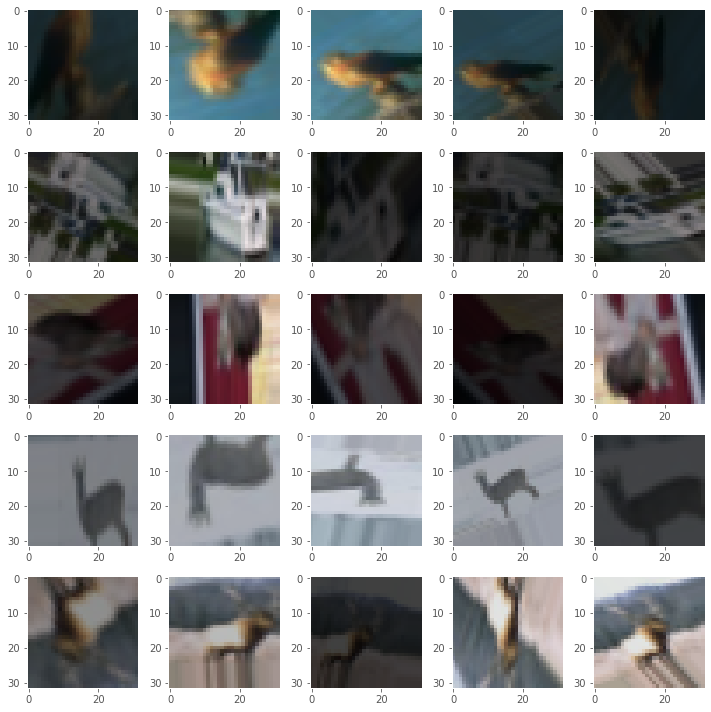

['bird' 'ship' 'cat' 'deer' 'deer']


In [0]:
plot_augmented_images(images_arr=augmented_tr_images)
print(class_labels[labs])

### Build the Model

In [0]:
cifar10_v0_4_3_model = tf.keras.Sequential(layers=[
  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu, 
                         input_shape=(32, 32, 3)), 
  tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=128, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=256, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=256, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Dropout(rate=0.2), 

  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(units=256, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
])

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [0]:
cifar10_v0_4_3_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [0]:
cifar10_v0_4_3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         5

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', save_best_only=True)

In [0]:
history = cifar10_v0_4_3_model.fit_generator(generator=train_data_generator, 
                                             epochs=100, 
                                             callbacks=[model_checkpoint], 
                                             validation_data=valid_data_generator)

In [0]:
data = {
    'train_loss' : history.history['loss'], 
    'train_acc' : history.history['accuracy'], 
    'val_loss' : history.history['val_loss'], 
    'val_acc' : history.history['val_accuracy']
}

history_df = pd.DataFrame(data=data, index=history.epoch)

In [0]:
display(history_df.head(10))
display(history_df.tail(10))

,train_loss,train_acc,val_loss,val_acc
0,1.989296,0.251525,1.729187,0.3686
1,1.791222,0.341225,1.608800,0.4224
2,1.695345,0.383600,1.491710,0.4579
3,1.634010,0.408450,1.410597,0.4855
4,1.574715,0.429000,1.378226,0.5052
5,1.541320,0.444050,1.372744,0.5047
6,1.512201,0.452950,1.315291,0.5330
7,1.489359,0.462325,1.378776,0.5125
8,1.468865,0.473075,1.351479,0.5232
9,1.447165,0.480700,1.327641,0.5404


,train_loss,train_acc,val_loss,val_acc
90,1.121656,0.607550,1.044365,0.6479
91,1.124445,0.607125,1.128938,0.6255
92,1.130604,0.606300,1.049102,0.6444
93,1.127706,0.607525,1.022874,0.6482
94,1.116302,0.608975,1.014988,0.6487
95,1.114953,0.607225,0.980609,0.6649
96,1.118102,0.608025,1.023741,0.6521
97,1.113014,0.606800,1.045601,0.6415
98,1.113243,0.610650,1.050515,0.6524
99,1.116545,0.611900,1.048753,0.6413


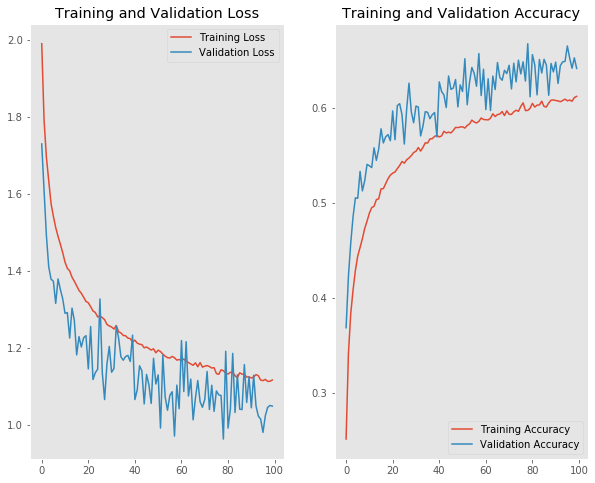

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(history_df.index, history_df.train_loss, label="Training Loss")
plt.plot(history_df.index, history_df.val_loss, label="Validation Loss")
plt.legend()
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(history_df.index, history_df.train_acc, label="Training Accuracy")
plt.plot(history_df.index, history_df.val_acc, label="Validation Accuracy")
plt.legend()
plt.grid(False)

plt.show()

In [0]:
cifar10_v0_4_3_model = tf.keras.models.load_model(filepath='./best_model.h5')

In [0]:
cifar10_v0_4_3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         5

In [0]:
image_data_gen_test = ImageDataGenerator(rescale=1./255)

In [0]:
test_data_generator = image_data_gen_test.flow(x=x_test, y=y_test)

In [0]:
print(len(test_data_generator))

313


In [0]:
test_img_batch = test_data_generator[0][0]
test_lab_batch = test_data_generator[0][1]

In [0]:
test_img_batch.shape

(32, 32, 32, 3)

In [0]:
test_lab_batch.shape

(32, 1)

In [0]:
prediction_batch = cifar10_v0_4_3_model.predict(x=test_img_batch)

In [0]:
print(prediction_batch)
print(prediction_batch.shape)

[[3.12569248e-03 4.14526602e-03 6.62482008e-02 4.26708311e-02
  4.85993236e-01 8.24696496e-02 4.88789640e-02 2.41522267e-01
  7.44853460e-04 2.42009833e-02]
 [2.28615638e-04 4.01643962e-02 2.16610169e-06 2.20697875e-05
  2.47973480e-06 9.83375594e-06 5.66901190e-06 1.46862631e-05
  1.15834884e-02 9.47966516e-01]
 [1.15142284e-05 5.24426969e-06 5.20125329e-02 4.42823442e-03
  8.36400449e-01 8.67915805e-03 4.49887328e-02 5.34332283e-02
  9.03538057e-06 3.18433886e-05]
 [3.81822261e-04 9.70519006e-01 2.56307521e-06 3.09148459e-06
  7.63310908e-08 2.01432840e-06 4.56458444e-08 2.51238635e-06
  4.42684250e-04 2.86462586e-02]
 [2.59819021e-03 8.73306941e-04 6.56773750e-07 3.93087612e-06
  1.13111611e-07 2.41812859e-06 7.59587770e-09 2.38172760e-07
  9.95975435e-01 5.45689370e-04]
 [1.47538085e-03 7.52828196e-02 1.00085335e-02 4.45168823e-01
  2.89013889e-03 3.53180289e-01 3.71839926e-02 1.35102989e-02
  1.36054019e-04 6.11636937e-02]
 [2.62039890e-07 8.10448825e-01 3.44617090e-09 3.61105967e

In [0]:
prediction_ids = np.argmax(a=prediction_batch, axis=1)

In [0]:
prediction_ids

array([4, 9, 4, 1, 8, 3, 1, 8, 4, 0, 1, 2, 0, 5, 1, 3, 5, 7, 9, 9, 2, 5,
       4, 5, 1, 6, 7, 6, 1, 9, 9, 9])

In [0]:
print("True Labels : {}".format(test_lab_batch.reshape((32))))
print("Predicitons : {}".format(prediction_ids))

True Labels : [4 9 4 1 8 3 1 8 4 0 9 2 0 5 1 3 5 7 0 9 4 3 4 7 8 6 0 4 1 9 3 9]
Predicitons : [4 9 4 1 8 3 1 8 4 0 1 2 0 5 1 3 5 7 9 9 2 5 4 5 1 6 7 6 1 9 9 9]


In [0]:
def plot_the_image(index_i, predict_batch_arr, actual_labels, images_tested):
  predict_batch_arr = predict_batch_arr[index_i]
  actual_label = actual_labels[index_i]
  image_testing = images_tested[index_i]

  plt.imshow(image_testing)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  predicted_label = np.argmax(predict_batch_arr)

  if predicted_label == actual_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{}  {:.2f}% ({})".format(class_labels[predicted_label], 
                                       100*np.max(predict_batch_arr), 
                                       class_labels[actual_label]), color=color)

def plot_the_predicted_array(index_i, predict_batch_arr, actual_labels):
  predict_batch_arr = predict_batch_arr[index_i]
  actual_label = actual_labels[index_i]

  this_plot = plt.bar(x=range(10), height=predict_batch_arr, color='#777777')
  plt.grid(False)
  plt.xticks(range(10))
  plt.ylim([0, 1])

  this_plot[np.argmax(predict_batch_arr)].set_color('red')
  this_plot[actual_label].set_color('green')

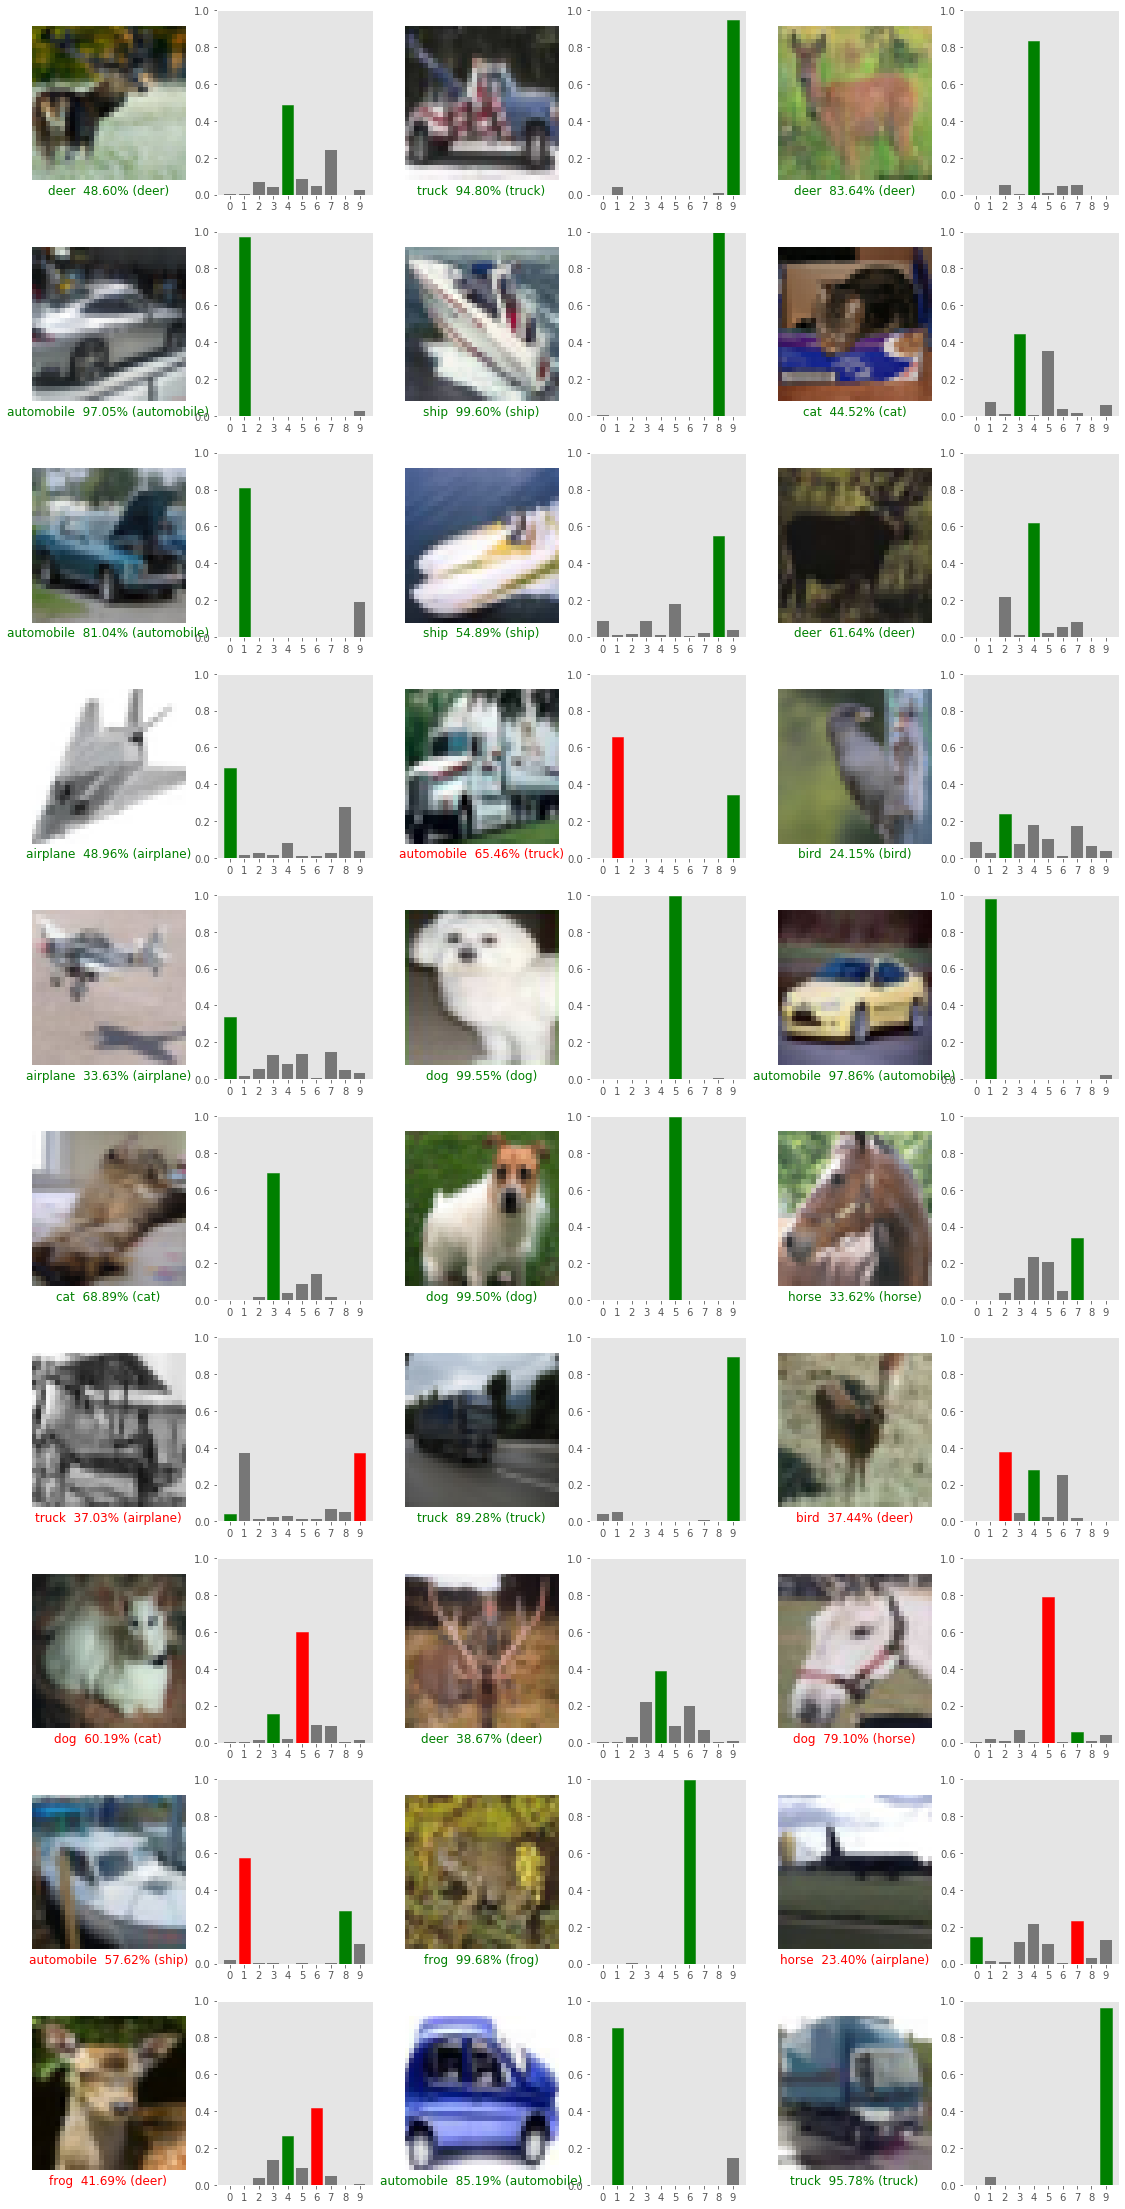

In [0]:
num_rows = 10
num_cols = 3
grid_size = num_rows * num_cols

plt.figure(figsize=((2*2+(2.5))*num_cols, (2*2)*num_rows))

for index_i in range(grid_size):
  plt.subplot(num_rows, 2*num_cols, 2*index_i+1)
  plot_the_image(index_i=index_i, 
                 predict_batch_arr=prediction_batch, 
                 actual_labels=test_lab_batch.reshape((32)), 
                 images_tested=test_img_batch)
  plt.subplot(num_rows, 2*num_cols, 2*index_i+2)
  plot_the_predicted_array(index_i=index_i, 
                           predict_batch_arr=prediction_batch, 
                           actual_labels=test_lab_batch.reshape((32)))
plt.show()